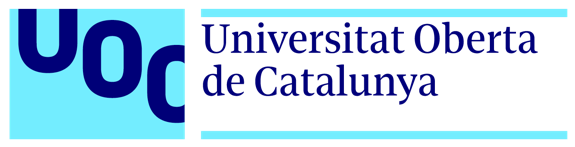

In [1]:
# Librerías de manipulación de datos
import pandas as pd
import numpy as np
import joblib

# Librerías de visualización de datos
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.legend_handler import HandlerLine2D

# Librerías de procesaso de datos
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold, RandomizedSearchCV
from sklearn.metrics import accuracy_score, balanced_accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve, auc
from sklearn.svm import SVC
from sklearn.inspection import permutation_importance

import warnings
warnings.filterwarnings("ignore")

1. Carga de los datos

2. Funciones generales

3. Generación máquina de soporte vectorial

4. Evaluación máquina de soporte vectorial

5. Características importantes

6. Guardado del mejor modelo

# 1. Carga de los datos

In [2]:
data = pd.read_csv("../data/case_control_episode.csv")
data.head()

,BreastCancer,Age,Family_History,episode_1,episode_2,episode_3,episode_4,episode_5,episode_6,episode_7,...,bbd_none,bbd_unknown,bbd_no_proliferative,bbd_proliferative,mf_none,mf_mass,mf_calcification,mf_asymetric_density,mf_distorsion,mf_multiple_patron
0,0.0,0.368421,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.105263,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.052632,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.000000,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.210526,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


# 2. Funciones generales

In [3]:
def grid_search(model, params, X_train, y_train):
    """
    Función genérica para aplicar la búsqueda de rejilla
    al modelo determinado mediante validación cruzada
    Args:
        model: modelo a aplicar a la búsqueda
        params: parámetros a comprobar
        X_train: datos de entrenamiento de los factores
        y_train: datos de entrenamiento de la clase
        cv: validación cruzada a aplicar
    Returns:
        Devuelve el mejor estimador entrenado
    """
    cv = KFold(n_splits=5, shuffle=True, random_state=1)
    
    model_search = GridSearchCV(estimator=model, param_grid=params,
                                scoring='accuracy', n_jobs=-1, cv=cv, refit=True)

    # Se entrena el mejor estimados
    model_search.fit(X_train, y_train)
    
    print("Los mejores parámetros son:", model_search.best_params_)

    return model_search

In [4]:
def evaluate_model(model, X_test, y_test):
    """
    Función genérica para evaluar los modelos
    Args:
        model: modelo a aplicar a la búsqueda
        X_test: datos de test de los factores
        y_test: datos de test de la clase
    """            
    y_pred_test = model.predict(X_test)
    
    test_confusion_matrix = confusion_matrix(y_test, y_pred_test)
    
    print("-"*50)
    print("Accuracy en test: ", accuracy_score(y_test, y_pred_test))
    print("-"*50)
    print("AUC: ", roc_auc_score(y_test, y_pred_test))
    print("-"*50)
    print("Clasificación en test: ")
    print(classification_report(y_test, y_pred_test))
    print("-"*50)
    print("Matriz de confusión en test: ")
    print(test_confusion_matrix)
    print("-"*50)
    sns.set(font_scale=1.4)
    svm_cm = sns.heatmap(test_confusion_matrix, annot=True, annot_kws={"size": 12}, fmt="g")
    plt.xlabel("Valores predichos");
    plt.ylabel("Valores reales"); 
    plt.show()
    figure = svm_cm.get_figure()
    figure.savefig("../plots/svm_model_confusion_matrix.png", bbox_inches="tight")


# 3. Generación máquina de soporte vectorial

## 3.1 Partición de los datos

In [5]:
# Partición de los datos en entrenamiento y test con una proporción 85/15

X = data.iloc[:, data.columns != "BreastCancer"].values.astype(float)
y = data.iloc[:, data.columns == "BreastCancer"].values.astype(float)

# Repartición balanceada
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=12)

## 3.2 Definición parámetros

In [6]:
svc_grid = {
    "C": [100, 200, 300, 400, 500, 600],
    "gamma": [0.001, 0.01, 0.1, 1, 10],
    "kernel": ["rbf"],
    "probability": [True],
    "random_state": [18]
}

## 3.3. Definición máquina de soporte vectorial

In [7]:
model = SVC()

## 3.4 Búsqueda de rejilla

In [8]:
%%time

result = grid_search(model, svc_grid, X_train, y_train.ravel())
    
# Mejor estimador
best_model = result.best_estimator_

Los mejores parámetros son: {'C': 400, 'gamma': 1, 'kernel': 'rbf', 'probability': True, 'random_state': 18}
CPU times: user 1min 56s, sys: 2.01 s, total: 1min 58s
Wall time: 1h 16min 28s


# 4. Evaluación máquina de soporte vectorial

Accuracy media sobre train, validación cruzada: 59.98 +/- 1.01 %
--------------------------------------------------
Accuracy en test:  0.61267217630854
--------------------------------------------------
AUC:  0.6117096872153053
--------------------------------------------------
Clasificación en test: 
              precision    recall  f1-score   support

         0.0       0.61      0.66      0.64       925
         1.0       0.62      0.56      0.59       890

    accuracy                           0.61      1815
   macro avg       0.61      0.61      0.61      1815
weighted avg       0.61      0.61      0.61      1815

--------------------------------------------------
Matriz de confusión en test: 
[[612 313]
 [390 500]]
--------------------------------------------------


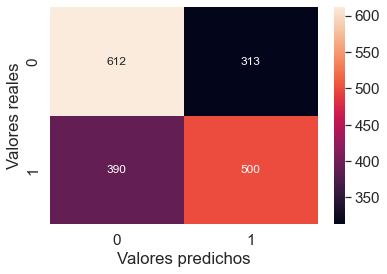

In [9]:
# Validación cruzada para determinar la confiabilidad del modelo
cv = KFold(n_splits=5, shuffle=True, random_state=1)
cvscores_random = cross_val_score(best_model, X_train, y_train, cv = cv)

print("Accuracy media sobre train, validación cruzada: "
      "{:.2f} +/- {:.2f} %".format(np.mean(cvscores_random)*100, np.std(cvscores_random)*100))

# Muestra de resultados sobre el mejor modelo
evaluate_model(best_model, X_test, y_test)

# 5. Características importantes

El método permutation_importance aplicado a los datos de entrenamiento permite ver cuánto depende el modelo de cada característica para hacer predicciones.

Age                     0.085912
Family_History          0.020301
episode_1               0.045173
episode_2               0.032261
episode_3               0.028469
episode_4               0.018862
episode_5               0.016646
episode_6               0.009859
episode_7               0.002645
episode_8               0.002042
episode_9               0.000525
episode_10              0.000194
bbd_none                0.030160
bbd_unknown             0.028430
bbd_no_proliferative    0.007642
bbd_proliferative       0.001945
mf_none                 0.019815
mf_mass                 0.029071
mf_calcification        0.015615
mf_asymetric_density    0.005484
mf_distorsion           0.001536
mf_multiple_patron      0.013087
dtype: float64


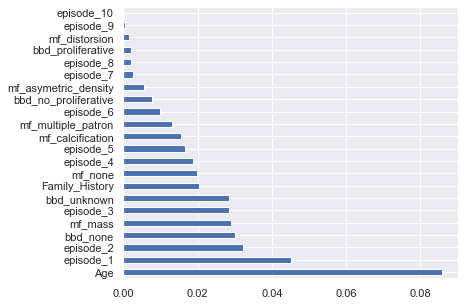

In [10]:
# Importancia de la característica de permutación
perm_importance = permutation_importance(best_model, X_train, y_train)

# Características importantes
importance_features = pd.Series(perm_importance.importances_mean,
                       index=data.iloc[:, 1: 23].columns)

# Muestra de las características
print(importance_features)
plt.figure(figsize=(6, 5))
plt.yticks(fontsize=11)
plt.xticks(fontsize=11)
importance_features.nlargest(22).plot.barh()
plt.savefig("../plots/svm_model_feature_importance.png", bbox_inches="tight")

In [11]:
# Se agrupan los resultados por variables originales

episode = importance_features.episode_1 + importance_features.episode_2 + importance_features.episode_3
+ importance_features.episode_4 + importance_features.episode_5 + importance_features.episode_6
+ importance_features.episode_7 + importance_features.episode_8 + importance_features.episode_9
+ importance_features.episode_10

bbd = importance_features.bbd_none + importance_features.bbd_unknown + importance_features.bbd_no_proliferative
+ importance_features.bbd_proliferative

mf = importance_features.mf_none + importance_features.mf_mass + importance_features.mf_calcification
+ importance_features.mf_asymetric_density + importance_features.mf_distorsion
+ importance_features.mf_multiple_patron

features_importance = []
features_importance.extend([])
features_importance.extend((importance_features.Age, episode, importance_features.Family_History, bbd, mf))
features_importance = np.array(features_importance)

Age                      0.085912
Episode                  0.105902
Family_History           0.020301
BBD_History              0.066232
Mammographic_Features    0.064502
dtype: float64


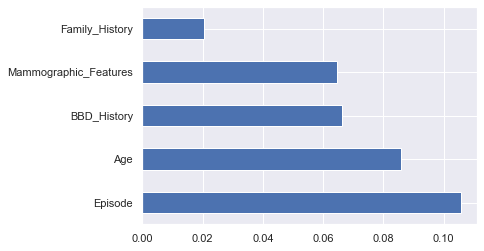

In [12]:
general_feature_importance = pd.Series(features_importance,
                       index=["Age", "Episode", "Family_History", "BBD_History", "Mammographic_Features"])

# Muestra de las características generales
print(general_feature_importance)
plt.figure(figsize=(6,4))
plt.yticks(fontsize=11)
plt.xticks(fontsize=11)
general_feature_importance.nlargest(5).plot.barh()
plt.savefig("../plots/svm_model_feature_importance_general.png", bbox_inches="tight")

In [13]:
data_x = data.iloc[:, data.columns != "BreastCancer"]

for i in perm_importance.importances_mean.argsort()[::-1]:
    if perm_importance.importances_mean[i] - 2 * perm_importance.importances_std[i] > 0:
        print(f"{data_x.columns[i]:<8} "
            f"{perm_importance.importances_mean[i]:.4f}"
            f" +/- {perm_importance.importances_std[i]:.4f}")

Age      0.0859 +/- 0.0037
episode_1 0.0452 +/- 0.0017
episode_2 0.0323 +/- 0.0030
bbd_none 0.0302 +/- 0.0022
mf_mass  0.0291 +/- 0.0026
episode_3 0.0285 +/- 0.0029
bbd_unknown 0.0284 +/- 0.0010
Family_History 0.0203 +/- 0.0019
mf_none  0.0198 +/- 0.0017
episode_4 0.0189 +/- 0.0006
episode_5 0.0166 +/- 0.0017
mf_calcification 0.0156 +/- 0.0014
mf_multiple_patron 0.0131 +/- 0.0014
episode_6 0.0099 +/- 0.0015
bbd_no_proliferative 0.0076 +/- 0.0016
mf_asymetric_density 0.0055 +/- 0.0016
episode_7 0.0026 +/- 0.0008
episode_8 0.0020 +/- 0.0006
bbd_proliferative 0.0019 +/- 0.0005
mf_distorsion 0.0015 +/- 0.0007
episode_9 0.0005 +/- 0.0001


# 6. Guardado del mejor modelo

In [14]:
joblib.dump(best_model, "../saved_models/svm_model.joblib")

['../saved_models/svm_model.joblib']